# Grab Repository data      

In [14]:

from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [15]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/commits_loc_changed_per_{BUCKET_SIZE}_days.csv'


# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [16]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")


Using INTRO_DATE from mapping file: 


# Generate Commit Metrics per Repository

## Amount of Commits over time

In [17]:
commit_result = []
aggregation_column = 'loc_changed'

for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    commit_file = f"{repository}/commits.csv"
    # Check if the file exists
    if not os.path.exists(commit_file):
        print(f"File not found: {commit_file}. Skipping repository.")
        continue
    commit_df = pd.read_csv(commit_file)
    
    commit_df['loc_changed'] = commit_df['loc_added'] + commit_df['loc_deleted']

    commit_df = truncate_to_same_length(commit_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    commit_df = aggregate_by_date(commit_df, 'date', aggregation_column, 'sum')
    
    pre_release, post_release = split_by_date(commit_df, INTRO_DATE, 'date')
    
    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', aggregation_column, 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', aggregation_column, 'sum', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')[aggregation_column].to_dict())  # Use 'count' instead of 'value'
    
    commit_result.append(result_row)

# Create the DataFrame
commit_result_df = pd.DataFrame(commit_result)


File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/commits.csv. Skipping repository.


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_60431/3713012636.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


In [18]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(commit_result_df, 'pre-', 'post-')
commit_result_df = commit_result_df[columns_order]

In [19]:
commit_result_df.to_csv(storage_path)
commit_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,12151.0,5185.0,1889.0,40186.0,1472.0,275.0,3629.0,319.0,23033.0,816.0,3077.0,30160.0,20715.0,17717.0,NaN,3052.0,2194.0,2246.0
1,P9,1289.0,798.0,93.0,48.0,934.0,799.0,498.0,NaN,601.0,767.0,4067.0,1547.0,330.0,43.0,NaN,339.0,144.0,123.0
2,P2,3341.0,1980.0,332.0,5838.0,882.0,1883.0,NaN,604.0,NaN,3081.0,3864.0,412.0,3272.0,2084.0,NaN,3760.0,2027.0,619.0
3,P8,5211.0,2514.0,8008.0,2020.0,10716.0,10325.0,3813.0,7715.0,24664.0,10253.0,7845.0,1918.0,7574.0,2118.0,NaN,35032.0,8986.0,5261.0
4,P1,3584.0,1648.0,390.0,2.0,8.0,19.0,6.0,6.0,4.0,0.0,13.0,2.0,0.0,NaN,0.0,NaN,6.0,4.0
5,k1bu0cscd4,130.0,NaN,152.0,NaN,1269.0,19.0,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,1019.0,1184.0,2096.0,108.0,1586.0,477.0,4607.0,1701.0,835.0,761.0,1100.0,3080.0,13301.0,66.0,429.0,1239.0,1042.0,821.0
7,P7,3011.0,893.0,138.0,1844.0,9434.0,468.0,5106.0,69.0,NaN,105.0,440.0,1333.0,771.0,237.0,4.0,14.0,640.0,390.0
8,P5,2218.0,372.0,1148.0,NaN,801.0,1703.0,NaN,NaN,NaN,7999.0,1214.0,2777.0,8257.0,15617.0,0.0,317.0,2447.0,706.0
9,P14,257.0,5485.0,1808.0,2673.0,3263.0,8064.0,1880.0,4554.0,248.0,15124.0,7463.0,823.0,1174.0,296.0,322.0,2294.0,581.0,292.0


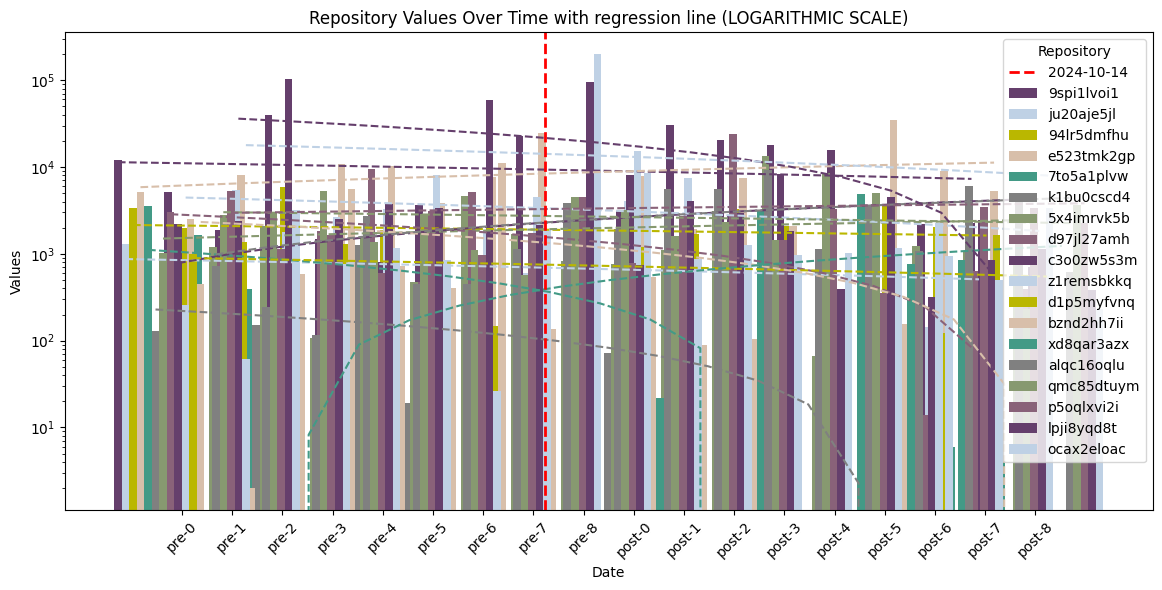

In [20]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()


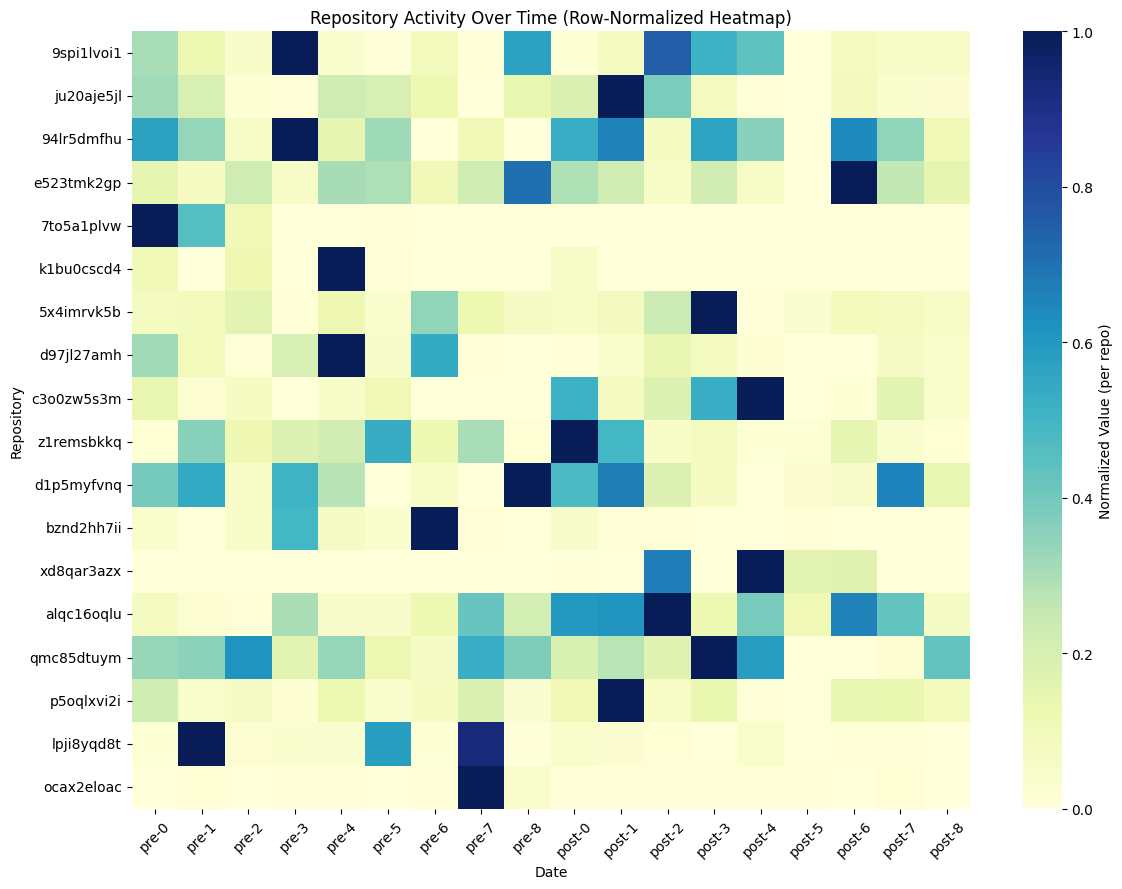

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
data_matrix = commit_result_df.set_index('repository').astype(float).fillna(0)

# Row-normalize: divide each row by its max (avoid division by 0)
normalized_data = data_matrix.div(data_matrix.max(axis=1).replace(0, np.nan), axis=0)

plt.figure(figsize=(12, 0.5 * len(normalized_data)))
sns.heatmap(normalized_data, cmap="YlGnBu", cbar_kws={'label': 'Normalized Value (per repo)'})
plt.title('Repository Activity Over Time (Row-Normalized Heatmap)')
plt.xlabel('Date')
plt.ylabel('Repository')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


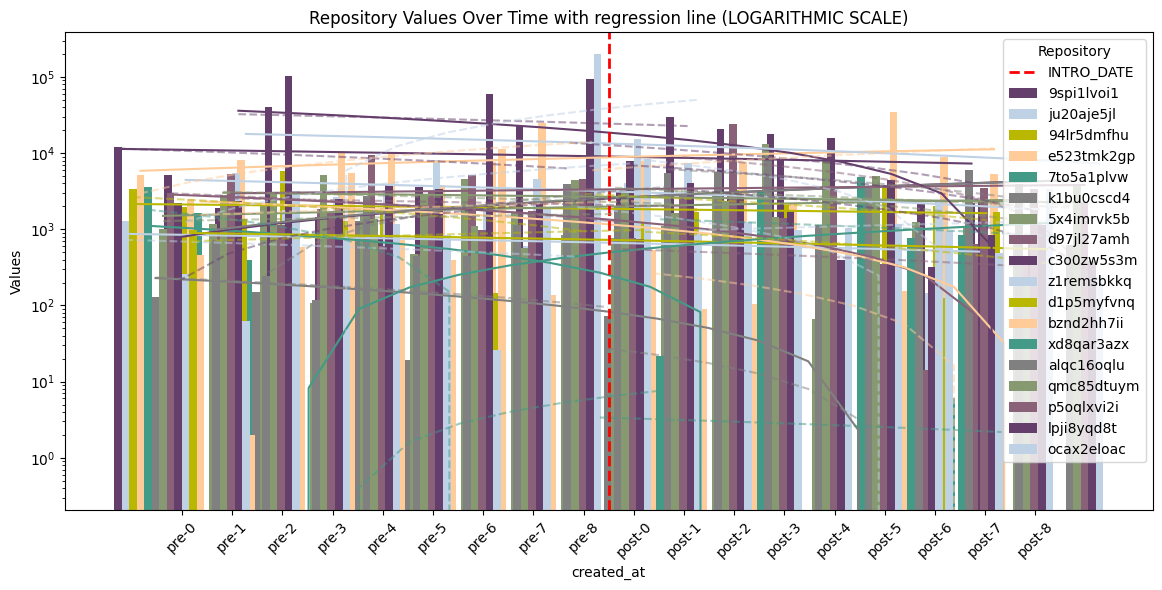

In [22]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(commit_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(commit_result_df['repository']):
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

# Significancetest 

In [23]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the commit_result_df
commit_result_df = commit_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in commit_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in commit_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(commit_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository   pre_p_value  after_p_value  pre_normal  after_normal
0   P3  5.549512e-03   9.450386e-03       False         False
1   P9  4.911137e-01   5.697956e-04        True         False
2   P2  5.598192e-02   2.519143e-01        True          True
3   P8  2.559621e-02   1.890761e-03       False         False
4   P1  1.211470e-04   2.412719e-03       False         False
5   k1bu0cscd4  5.287378e-06   3.217493e-07       False         False
6   5x4imrvk5b  5.265588e-02   2.821757e-05        True         False
7   P7  1.204508e-02   2.629578e-01       False          True
8   P5  5.224485e-02   2.785356e-02        True         False
9   P14  5.257101e-01   3.888987e-04        True         False
10  P6  1.405718e-01   2.649611e-02        True         False
11  bznd2hh7ii  1.666417e-04   2.904815e-04       False         False
12  xd8qar3azx  1.000000e+00   1.173167e-03        True         False
13  P4  7.391454e-02   4.750394e-01        True          True
14  P13  6.334568e-01   1.087

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [24]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, commit_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(commit_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta    -0.012346 -0.604938  0.531481
1   P9  Cliff's Delta    -0.098765 -0.642284  0.481481
2   P2  Cliff's Delta     0.283951 -0.234568  0.777778
3   P8  Cliff's Delta    -0.135802 -0.654321  0.432099
4   P1  Cliff's Delta    -0.753086 -0.987654 -0.358025
5   k1bu0cscd4  Cliff's Delta    -0.358025 -0.753086  0.037037
6   5x4imrvk5b  Cliff's Delta    -0.135802 -0.654321  0.432099
7   P7  Cliff's Delta    -0.358025 -0.851852  0.209877
8   P5  Cliff's Delta     0.555556  0.086420  0.925926
9   P14  Cliff's Delta    -0.185185 -0.777778  0.407407
10  P6  Cliff's Delta    -0.049383 -0.555864  0.531173
11  bznd2hh7ii  Cliff's Delta    -0.641975 -0.975309 -0.197531
12  xd8qar3azx  Cliff's Delta     0.555556  0.222222  0.888889
13  P4  Cliff's Delta     0.679012  0.234568  0.975309
14  P13  Cliff's Delta    -0.185185 -0.777778  0.408025
15  P12  Cliff's Delta     0.135802 -0.407407  0.728395
16  P10  Cliff's Delta

In [25]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,12151.0,5185.0,1889.0,40186.0,1472.0,275.0,3629.0,319.0,23033.0,...,20715.0,17717.0,0.0,3052.0,2194.0,2246.0,Cliff's Delta,-0.012346,-0.604938,0.531481
1,P9,1289.0,798.0,93.0,48.0,934.0,799.0,498.0,0.0,601.0,...,330.0,43.0,0.0,339.0,144.0,123.0,Cliff's Delta,-0.098765,-0.642284,0.481481
2,P2,3341.0,1980.0,332.0,5838.0,882.0,1883.0,0.0,604.0,0.0,...,3272.0,2084.0,0.0,3760.0,2027.0,619.0,Cliff's Delta,0.283951,-0.234568,0.777778
3,P8,5211.0,2514.0,8008.0,2020.0,10716.0,10325.0,3813.0,7715.0,24664.0,...,7574.0,2118.0,0.0,35032.0,8986.0,5261.0,Cliff's Delta,-0.135802,-0.654321,0.432099
4,P1,3584.0,1648.0,390.0,2.0,8.0,19.0,6.0,6.0,4.0,...,0.0,0.0,0.0,0.0,6.0,4.0,Cliff's Delta,-0.753086,-0.987654,-0.358025
5,k1bu0cscd4,130.0,0.0,152.0,0.0,1269.0,19.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.358025,-0.753086,0.037037
6,5x4imrvk5b,1019.0,1184.0,2096.0,108.0,1586.0,477.0,4607.0,1701.0,835.0,...,13301.0,66.0,429.0,1239.0,1042.0,821.0,Cliff's Delta,-0.135802,-0.654321,0.432099
7,P7,3011.0,893.0,138.0,1844.0,9434.0,468.0,5106.0,69.0,0.0,...,771.0,237.0,4.0,14.0,640.0,390.0,Cliff's Delta,-0.358025,-0.851852,0.209877
8,P5,2218.0,372.0,1148.0,0.0,801.0,1703.0,0.0,0.0,0.0,...,8257.0,15617.0,0.0,317.0,2447.0,706.0,Cliff's Delta,0.555556,0.086420,0.925926
9,P14,257.0,5485.0,1808.0,2673.0,3263.0,8064.0,1880.0,4554.0,248.0,...,1174.0,296.0,322.0,2294.0,581.0,292.0,Cliff's Delta,-0.185185,-0.777778,0.407407


# Interpretation
- 1, -> less LOC changed after introduction
- 3,5 -> more LOC changed after introduction
- Effect size ranges from medium to big